# New Dataset Face Detection

In [1]:
# loading libraries
# System
import os
import joblib
from collections import Counter

# Image processing
import skimage
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

# Data Processing
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [2]:
# load functions and classes
from resizedata import resize_data
from rgb2graytransformer import RGB2GrayTransformer
from hogtransformer import HogTransformer

In [3]:
data_path2 = r'C:\Users\straw\Desktop\AIS\ProjectPool 2\Classification-images\Data\afhq'
print(os.listdir(data_path2))

['CatHead', 'DogHead', 'WildHead']


In [4]:
pklname2 = 'output2'

In [5]:
width = 80
include2 = {'CatHead','DogHead', 'WildHead'}

In [6]:
#resize_data(path=data_path2, pklname=pklname2, include=include2, width=width)

In [7]:
data2 = joblib.load(f'Output/{pklname2}_{width}x{width}px.pkl')
 
print('Number of samples: ', len(data2['data']))
print('Keys: ', list(data2.keys()))
print('Description: ', data2['description'])
print('Images shape: ', data2['data'][0].shape)
print('Labels:', np.unique(data2['label']))

Number of samples:  16130
Keys:  ['description', 'label', 'filename', 'data']
Description:  resized (80x80)animal images in rgb
Images shape:  (80, 80, 3)
Labels: ['Cat' 'Dog' 'Wild']


In [8]:
Counter(data2['label'])

Counter({'Cat': 5653, 'Dog': 5239, 'Wild': 5238})

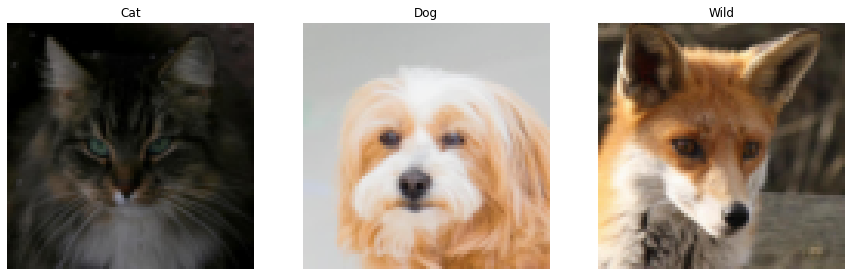

In [9]:
labels = np.unique(data2['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,15)
for ax, label in zip(axes, labels):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [10]:
X_bis = np.array(data2['data'])
y_bis = np.array(data2['label'])

In [11]:
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X_bis, y_bis, test_size=0.2, shuffle=True, stratify=y_bis)

In [12]:
print(Counter(y_bis))
print(Counter(y_train_bis))
print(Counter(y_test_bis))

Counter({'Cat': 5653, 'Dog': 5239, 'Wild': 5238})
Counter({'Cat': 4522, 'Wild': 4191, 'Dog': 4191})
Counter({'Cat': 1131, 'Dog': 1048, 'Wild': 1047})


In [13]:
unique_ytrain, counts_ytrain = np.unique(y_train_bis, return_counts=True)
unique_ytest, counts_ytest = np.unique(y_test_bis, return_counts=True)

trace1 = go.Bar(y=100*counts_ytrain/len(y_train_bis), x=unique_ytrain, name='Dataset y_train')
trace2 = go.Bar(y=100*counts_ytest/len(y_test_bis), x=unique_ytest, name='Dataset y_test')

data = [trace1, trace2]
layout = dict(title = 'Quantité relative de photos par dataset', yaxis = dict(title = '% Counts'), xaxis = dict(title = 'Labels'))
fig = dict(data = data, layout = layout)
iplot(fig)

## Pipeline

In [14]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')),
    ('scalify', StandardScaler()),
    ('classify', svm.SVC(kernel='linear'))
])

clf = HOG_pipeline.fit(X_train_bis, y_train_bis)
print('Percentage correct :', 100*np.sum(clf.predict(X_test_bis) == y_test_bis)/len(y_test_bis))

Percentage correct : 89.46063236205828


## GreadSearch

In [15]:
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'scalify': [
            StandardScaler(),
            Normalizer(),
            MinMaxScaler(),
            #RobustScaler(),
            #MaxAbsScaler()
        ],
        'classify': [
            SGDClassifier(max_iter=1000, tol=1e-3),
            #svm.SVC(kernel='linear'),
            svm.SVC(kernel='poly'),
            #svm.SVC(kernel='sigmoid'),
            #svm.SVC(kernel='precomputed'),
            #svm.SVC(),
            GaussianNB(),
            #MultinomialNB(), 
            #BernoulliNB()
        ]
    }
]

In [ ]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train_bis, y_train_bis)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# save the model to disk
joblib.dump(grid_res, 'Output\models\hog_models2.pkl')

In [ ]:
print('Best Estimator :',grid_res.best_estimator_)